DeepLarning Couse MSU 2016 fall: 
* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин ```jheuristic@yandex-team.ru```
* ```https://vk.com/ars.ashuha```

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.



In [1]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-04-02 05:30:30--  https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/pff0Qj952jjdoMXgq0fElitDA49VLD4whbSruGviNnrDEoSqImKFUYxFXZ4UahdI/file?dl=1 [following]
--2017-04-02 05:30:32--  https://dl.dropboxusercontent.com/content_link/pff0Qj952jjdoMXgq0fElitDA49VLD4whbSruGviNnrDEoSqImKFUYxFXZ4UahdI/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 482,77M  2,42MB/s    in 4m 24s  

2017-04-02 05:34:57 (1,83 MB/s) - ‘data.tar.gz’ s

### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 4.3 s, sys: 2.66 s, total: 6.97 s
Wall time: 15.4 s


In [2]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [4]:
#captions[0]

In [5]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
#word_counts = <here should be dict word:number of entrances>

from collections import Counter
word_counts = Counter(word for capt_i in captions for sent in capt_i for word in sent )

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k != "#START#" and k != "#END#"]
n_tokens = len(vocab)

print n_tokens
assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

10371


In [6]:
for i, w in enumerate(vocab):
    if i == 1:
        print w

#START#


In [7]:
print word_to_index.get("#START#", UNK_ix)

NameError: name 'UNK_ix' is not defined

In [8]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [9]:
#try it out on several descriptions of a random image
print captions[1337]
print "\n"
print as_matrix(captions[1337])

[['#START#', u'an', u'old', u'black', u'and', u'white', u'photo', u'of', u'two', u'men', u'in', u'suits', '#END#'], ['#START#', u'two', u'men', u'are', u'pictured', u'wearing', u'suits', u'in', u'this', u'historical', u'photo', '#END#'], ['#START#', u'a', u'black', u'and', u'white', u'photo', u'of', u'two', u'young', u'gentlemen', u'next', u'to', u'each', u'other', '#END#'], ['#START#', u'a', u'man', u'standing', u'leaning', u'on', u'a', u'man', u'sitting', '#END#'], ['#START#', u'an', u'old', u'black', u'and', u'white', u'photo', u'of', u'two', u'men', u'next', u'to', u'eachother', '#END#']]


[[    1  2852  7829  4136 10056  9932  5915  4859  6766  1243  3980  6254
      2    -1    -1]
 [    1  6766  1243  8900  1021  9093  6254  3980  8255   727  5915     2
     -1    -1    -1]
 [    1  8715  4136 10056  9932  5915  4859  6766  5627  8637   535  5470
   7115  5155     2]
 [    1  8715  8895  3069  2538   781  8715  8895  1558     2    -1    -1
     -1    -1    -1]
 [    1  2852  782

### Mah Neural Network

In [14]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [11]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [12]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [13]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
#l_word_embeddings = <Embedding Layer>
l_word_embeddings = EmbeddingLayer(l_words,input_size=n_tokens,output_size=EMBED_SIZE )

In [78]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
#l_image_features_small = <Apply Dropout Layer to regularise your Net>
#l_image_features_small = <Apply Dense to acive LSTM_UNITS size of representation>

l_image_features_small = DropoutLayer(l_image_features,  p=0.5)
l_image_features_small = DenseLayer(l_image_features_small, num_units=LSTM_UNITS)

assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [79]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
"""decoder = LSTMLayer(<Hmmm, what whould be here?>,
                    num_units=LSTM_UNITS,
                    cell_init=<Use your brain =)>,
                    mask_input=<Mask?>,
                    grad_clipping=<boom grads>)"""
decoder = LSTMLayer(incoming=l_word_embeddings, 
                    num_units=LSTM_UNITS,\
                    cell_init=l_image_features_small,\
                    mask_input=l_mask,
                    grad_clipping=1.5)

In [80]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10371) # there was 10373

broadcasted decoder shape =  (None, 1000)
output shape =  (None, None, 10371)


In [81]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
#loss = <mean over non-PAD tokens>
loss = loss.sum() / output_mask.sum()

In [82]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
#weights = <all dnn weigts>
#updates = <your favorite optimizer>

weights = lasagne.layers.get_all_params(predicted_probabilities)
print weights
updates = lasagne.updates.adadelta(loss_or_grads=loss, params=weights)

[W, W, b, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, hid_init, W, b]


In [83]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors, sentences], outputs=loss, updates=updates)
val_step   = theano.function([image_vectors, sentences], outputs=loss, updates=None)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [84]:
captions = np.array(captions)

In [85]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [86]:
generate_batch(img_codes,captions, 3)

(array([[-1.79477823, -1.37881052, -2.09767222, ...,  0.44046181,
          2.83814001,  0.79821908],
        [-4.39648581, -2.00502944, -1.20266044, ..., -0.72086215,
          0.62649989,  0.2530331 ],
        [-1.01349211, -0.27801889, -1.68175256, ..., -1.71702814,
          1.12565541,  3.24617338]], dtype=float32),
 array([[   1, 8715, 8895, 9093, 8715, 9462, 3974, 3069, 3980, 3323, 4556,
            2],
        [   1, 9339, 8798, 8715, 6435, 3980, 8715, 1872, 4701,    2,   -1,
           -1],
        [   1, 8715, 8895, 5643,  326, 8715, 9860, 5747, 3980, 8715,  181,
            2]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [87]:
batch_size = 50 #adjust me
n_epochs   = 100 #adjust me
n_batches_per_epoch = 30 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [88]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 0, train loss: 7.57373702352, val loss: 5.37274806301


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 1, train loss: 5.18423487147, val loss: 4.90258389053


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.89044327753, val loss: 4.67728365625


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 3, train loss: 4.68832542895, val loss: 4.49831240823


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.54374010508, val loss: 4.44736173986


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 5, train loss: 4.43552976628, val loss: 4.39713133451


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 6, train loss: 4.31310853073, val loss: 4.19512254994


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 7, train loss: 4.23398114553, val loss: 4.15907668485


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 8, train loss: 4.14942593863, val loss: 4.09735121229


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.0785786185, val loss: 4.03595000355


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.0592963058, val loss: 4.02497435108


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 11, train loss: 4.01260402894, val loss: 3.95880912138


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 12, train loss: 4.01732107019, val loss: 3.85747083142


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.91228614819, val loss: 3.86749314189


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.89271420515, val loss: 3.90704628374


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.80854968826, val loss: 3.74176675286


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.81071721312, val loss: 3.7320761356


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.74231480924, val loss: 3.70116400228


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.72451452546, val loss: 3.75400835043


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.72648140036, val loss: 3.71754694165


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.67090050957, val loss: 3.68667376316


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 21, train loss: 3.69104081021, val loss: 3.60138515434


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 22, train loss: 3.6820361042, val loss: 3.77859225484


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 23, train loss: 3.63329595196, val loss: 3.52408801881


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 24, train loss: 3.64147166801, val loss: 3.5407426387


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 25, train loss: 3.71566251543, val loss: 3.70925562585


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 26, train loss: 3.61734509787, val loss: 3.54770392072


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 27, train loss: 3.56180282559, val loss: 3.69426483596


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 28, train loss: 3.53299816034, val loss: 3.55372907886


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 29, train loss: 3.50846313759, val loss: 3.54805651419


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 30, train loss: 3.58559054241, val loss: 3.58798976201


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 31, train loss: 3.51939545319, val loss: 3.52948077793


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 32, train loss: 3.52242807408, val loss: 3.58657356772


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 33, train loss: 3.50855548658, val loss: 3.40224683342


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 34, train loss: 3.48835589492, val loss: 3.45361009368


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 35, train loss: 3.53192976013, val loss: 3.43552233866


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 36, train loss: 3.46272005999, val loss: 3.53915612573


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 37, train loss: 3.49283180176, val loss: 3.40358409854


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 38, train loss: 3.4991289917, val loss: 3.5255869943


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 39, train loss: 3.5235099794, val loss: 3.31906457848


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 40, train loss: 3.4496623207, val loss: 3.45745527467


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 41, train loss: 3.4173976562, val loss: 3.42452880576


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 42, train loss: 3.42779249442, val loss: 3.35812307924


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 43, train loss: 3.35713135415, val loss: 3.36549003434


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 44, train loss: 3.45197976879, val loss: 3.41496217168


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 45, train loss: 3.38036562603, val loss: 3.37547684212


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 46, train loss: 3.42819001788, val loss: 3.37375942572


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 47, train loss: 3.43286491484, val loss: 3.40371511834


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 48, train loss: 3.37123169269, val loss: 3.40756112783


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 49, train loss: 3.32769582199, val loss: 3.30062969474


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 50, train loss: 3.38417960974, val loss: 3.37722345818


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 51, train loss: 3.35204509601, val loss: 3.26011793895


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 52, train loss: 3.41134467209, val loss: 3.3940004888


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 53, train loss: 3.36244123877, val loss: 3.43771903761


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 54, train loss: 3.29099297315, val loss: 3.34029670126


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 55, train loss: 3.35810490869, val loss: 3.36324962595


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 56, train loss: 3.31804466879, val loss: 3.36235856074


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 57, train loss: 3.28681919541, val loss: 3.32974882799


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 58, train loss: 3.35465221313, val loss: 3.3758452468


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 59, train loss: 3.32532633237, val loss: 3.30189049587


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 60, train loss: 3.30936646841, val loss: 3.40767080515


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 61, train loss: 3.31702715224, val loss: 3.16139332593


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 62, train loss: 3.27913599835, val loss: 3.29749413803


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 63, train loss: 3.34188448287, val loss: 3.32522555745


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 64, train loss: 3.28850259088, val loss: 3.25669992545


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 65, train loss: 3.24743708672, val loss: 3.29466171135


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 66, train loss: 3.28900782475, val loss: 3.32873445723


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 67, train loss: 3.22408062598, val loss: 3.27083873236


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 68, train loss: 3.30233354369, val loss: 3.23424799791


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 69, train loss: 3.253340429, val loss: 3.31553115605


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 70, train loss: 3.26259641813, val loss: 3.25832307241


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 71, train loss: 3.28979204672, val loss: 3.18085490402


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 72, train loss: 3.27727579121, val loss: 3.25965539632


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 73, train loss: 3.23872406789, val loss: 3.25872694173


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 74, train loss: 3.29863254639, val loss: 3.25530682397


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 75, train loss: 3.19574109087, val loss: 3.17608065038


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 76, train loss: 3.24881868415, val loss: 3.21731168386


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 77, train loss: 3.24766221627, val loss: 3.21494804441


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 78, train loss: 3.20028048111, val loss: 3.17361330586


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 79, train loss: 3.30697052352, val loss: 3.27841439859


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 80, train loss: 3.24804531447, val loss: 3.31351839165


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 81, train loss: 3.23141650879, val loss: 3.18331625512


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 82, train loss: 3.27019281129, val loss: 3.33548373807


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 83, train loss: 3.16552102557, val loss: 3.31237691447


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 84, train loss: 3.23079311353, val loss: 3.22093810573


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 85, train loss: 3.19457971571, val loss: 3.04615923722


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 86, train loss: 3.19774191183, val loss: 3.14334642729


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 87, train loss: 3.14817710221, val loss: 3.13583991873


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 88, train loss: 3.21889596964, val loss: 3.25856320816


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 89, train loss: 3.21691138699, val loss: 3.19748871598


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 90, train loss: 3.22947250955, val loss: 3.174121002


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 91, train loss: 3.19365294176, val loss: 3.15342598464


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 92, train loss: 3.15222998186, val loss: 3.20114698094


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 93, train loss: 3.16619027047, val loss: 3.21426118288


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 94, train loss: 3.17281943262, val loss: 3.34214928316


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 95, train loss: 3.19938903069, val loss: 3.2752458642


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 96, train loss: 3.16024711094, val loss: 3.21466514999


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 97, train loss: 3.12116865692, val loss: 3.20542552755


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 98, train loss: 3.1629372159, val loss: 3.18309223666


100%|██████████| 30/30 [05:58<00:00, 11.75s/it]



Epoch: 99, train loss: 3.17733228944, val loss: 3.29317399643
Finish :)


### apply trained model

In [89]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [90]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

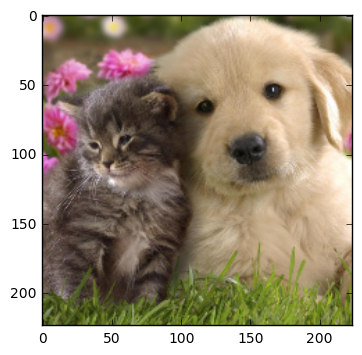

In [91]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [92]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

a small dog eating laying on a listen vase
five marina vitamin in their urban toy back
a drooping and some silver in her portraits
the adorable making looking food with a cat on the top of a canopy
black and white in a blue shirt with remotes lying beside the luggage
group of cats sitting together underneath on the backyard
a child sitting on the floor inside of the refrigerator
close up of brown have white bears colors on top of cutters
a suitcases is sleeping in front of a bowl covered door
one teddy bear with a tie at a fence


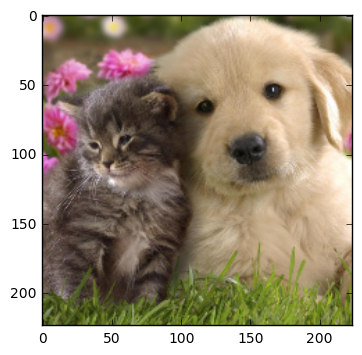

In [96]:
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a photo of country feeding #UNK# stand in ocean
a gingham adult cute brown dog with a horse to red looking into a brown mountain to by a body of wall
a dog who is standing in the with grass
the dog sitting in a fenced riding into rocks
one elephant leaning on across ground with a horse on the shore behind the water
a cow standing next to a small bird
a dog standing down next to know a snowboard
a man riding a dog in the snow
plains in a bear standing on the sand by a boasts and boogie soldiers
a dog trunk against the snowboards of a game of compartmentalized


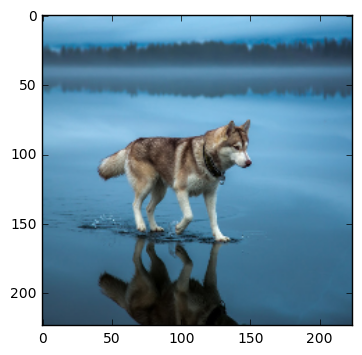

In [101]:
img = plt.imread('data/5.jpg')
img = preprocess(img)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])